# Ajuste de hiperparámetros

Denominamos **hiperparámetros** a aquellos parámetros que influyen en el proceso de aprendizaje. Existen formas de ajustarlos para que los modelos lleven a cabo predicciones más precisas y generalicen mejor. Es un proceso muy automatizable, pero se pueden ajustar "a mano".

Veamos cómo influyen en el desempeño de un modelo con un caso práctico:

## Carga de datos

In [1]:
from sklearn import datasets
import pandas as pd
import numpy as np

# cargamos los datos
bc = datasets.load_breast_cancer()

# convertimos a dataframe, separando la variable objetivo como siempre
X = pd.DataFrame(data=bc.data, columns=bc['feature_names'])
y = pd.DataFrame(data=bc.target, columns=['target'])

In [2]:
print(bc.DESCR)

.. _breast_cancer_dataset:

Breast cancer wisconsin (diagnostic) dataset
--------------------------------------------

**Data Set Characteristics:**

    :Number of Instances: 569

    :Number of Attributes: 30 numeric, predictive attributes and the class

    :Attribute Information:
        - radius (mean of distances from center to points on the perimeter)
        - texture (standard deviation of gray-scale values)
        - perimeter
        - area
        - smoothness (local variation in radius lengths)
        - compactness (perimeter^2 / area - 1.0)
        - concavity (severity of concave portions of the contour)
        - concave points (number of concave portions of the contour)
        - symmetry
        - fractal dimension ("coastline approximation" - 1)

        The mean, standard error, and "worst" or largest (mean of the three
        worst/largest values) of these features were computed for each image,
        resulting in 30 features.  For instance, field 0 is Mean Radi

Vamos a partir el dataset en entrenamiento y test para evaluar más adelante las predicciones:

In [3]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

## Modelo y ejemplo para un hiperparámetro

Vamos a estudiar el comportamiento de un `XGBoostClassifier` a medida que cambiamos sus [hiperparámetros](https://www.kaggle.com/code/prashant111/a-guide-on-xgboost-hyperparameters-tuning/notebook). Para ello, tendremos que fijarnos en sus medidas de calidad según el valor va ajustándose.

Veamos, por ejemplo, cómo afecta el parámetro `tree_method` a las medidas de calidad.

In [4]:
import xgboost as xgb

# Esta es una prueba donde también podemos demostrar lo "automatizable" que es este proceso.
# Por ejemplo, aquí podemos probar automáticamente 3 valores diferentes para este hiperparámetro.
tree_method = ['exact', 'approx', 'hist']
train_scores = np.array([])
test_scores = np.array([])

# Entrenamos el modelo con un valor distinto de tree_method cada vez y anotamos resultados en los arrays
for i in tree_method:
  classifier = xgb.XGBClassifier(tree_method=i, random_state=42).fit(X_train, y_train)
  train_scores = np.append(train_scores, classifier.score(X_train, y_train))
  test_scores = np.append(test_scores, classifier.score(X_test, y_test))

In [5]:
print(test_scores)

[0.97340426 0.96808511 0.95212766]


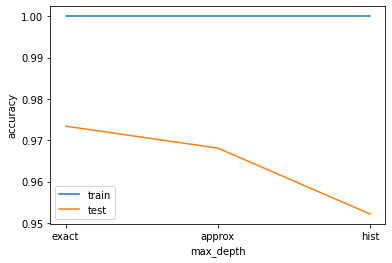

In [6]:
import matplotlib.pyplot as plt

plt.figure()

plt.plot(tree_method, train_scores, label="train")
plt.plot(tree_method, test_scores, label="test")

plt.xlabel('max_depth')
plt.ylabel('accuracy')

plt.legend()

## Múltiples hiperparámetros

Para optimizar dos hiperparámetros, se puede representar el progreso con un mapa de calor relacionando los cambios en los valores de ambos hiperparámetros.

Sin embargo, lo más común en estos casos es ajustar con múltiples hiperparámetros, lo cual es casi imposible de representar gráficamente, por lo que a menudo se recurre a tablas para representar la evolución del modelo.

Utilizaremos [`GridSearchCV`](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html) para probar todas las combinaciones de hiperparámetros que queramos.

In [7]:
from sklearn.model_selection import GridSearchCV

params = {
  'n_estimators': np.arange(5,51,10),
  'max_depth': np.arange(1,30,5),
  'tree_method': ['exact', 'approx', 'hist']
}

model = xgb.XGBClassifier(random_state=42)
gs = GridSearchCV(model, params, verbose=1, n_jobs=-1, cv=3)
gs.fit(X, y)

Fitting 3 folds for each of 90 candidates, totalling 270 fits


GridSearchCV(cv=3,
             estimator=XGBClassifier(base_score=None, booster=None,
                                     callbacks=None, colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None,
                                     early_stopping_rounds=None,
                                     enable_categorical=False, eval_metric=None,
                                     feature_types=None, gamma=None,
                                     gpu_id=None, grow_policy=None,
                                     importance_type=None,
                                     interaction_constraints=None,
                                     learning_rate=None,...
                                     max_cat_to_onehot=None,
                                     max_delta_step=None, max_depth=None,
                                     max_leaves=None, min_child_weight=None,
                                     missing=nan, monotone_constraints=None,
                                     n_estimators=100, n_jobs=None,
                                     num_parallel_tree=None, predictor=None,
                                     random_state=42, ...),
             n_jobs=-1,
             param_grid={'max_depth': array([ 1,  6, 11, 16, 21, 26]),
                         'n_estimators': array([ 5, 15, 25, 35, 45]),
                         'tree_method': ['exact', 'approx', 'hist']},
             verbose=1)

Visualizamos ahora la tabla:

In [8]:
pd.DataFrame(gs.cv_results_).sort_values('rank_test_score')

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_max_depth,param_n_estimators,param_tree_method,params,split0_test_score,split1_test_score,split2_test_score,mean_test_score,std_test_score,rank_test_score
44,0.167493,0.103526,0.034075,0.029505,11,45,hist,"{'max_depth': 11, 'n_estimators': 45, 'tree_me...",0.952632,0.978947,0.968254,0.966611,0.010806,1
86,0.245978,0.046555,0.020818,0.006675,26,35,hist,"{'max_depth': 26, 'n_estimators': 35, 'tree_me...",0.952632,0.978947,0.968254,0.966611,0.010806,1
74,0.134908,0.038129,0.007492,0.000524,21,45,hist,"{'max_depth': 21, 'n_estimators': 45, 'tree_me...",0.952632,0.978947,0.968254,0.966611,0.010806,1
71,0.210583,0.144795,0.020655,0.018288,21,35,hist,"{'max_depth': 21, 'n_estimators': 35, 'tree_me...",0.952632,0.978947,0.968254,0.966611,0.010806,1
59,0.408625,0.055868,0.024523,0.017121,16,45,hist,"{'max_depth': 16, 'n_estimators': 45, 'tree_me...",0.952632,0.978947,0.968254,0.966611,0.010806,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16,0.125323,0.051251,0.018307,0.012919,6,5,approx,"{'max_depth': 6, 'n_estimators': 5, 'tree_meth...",0.931579,0.968421,0.925926,0.941975,0.018842,83
76,0.150151,0.047531,0.018157,0.014150,26,5,approx,"{'max_depth': 26, 'n_estimators': 5, 'tree_met...",0.931579,0.968421,0.925926,0.941975,0.018842,83
2,0.025366,0.002058,0.007021,0.000240,1,5,hist,"{'max_depth': 1, 'n_estimators': 5, 'tree_meth...",0.905263,0.926316,0.941799,0.924459,0.014973,88
1,0.024053,0.002874,0.007466,0.000426,1,5,approx,"{'max_depth': 1, 'n_estimators': 5, 'tree_meth...",0.894737,0.931579,0.941799,0.922705,0.020212,89


... Aunque podemos simplemente visualizar los parámetros que dan el mejor resultado:

In [9]:
print('Mejor puntuación:', gs.best_score_)
print('Parámetros que la han conseguido:', gs.best_params_)

Mejor puntuación: 0.9666109718741298
Parámetros que la han conseguido: {'max_depth': 6, 'n_estimators': 35, 'tree_method': 'hist'}


El problema de *GridSearch* es que tiene un coste computacional muy alto, ya que puede llegar a probar una cantidad enorme de combinaciones y dispara el coste computacional. Hay que elegir los hiperparámetros y los posibles valores con cabeza, pero como alternativa disponemos de [`RandomizedSearchCV`](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.RandomizedSearchCV.html) que selecciona aleatoriamente combinaciones de hiper-parámetros dentro del rango elegido.

In [10]:
from sklearn.model_selection import RandomizedSearchCV

params = {
  'n_estimators': np.arange(5,51,10),
  'max_depth': np.arange(1,30,5),
  'tree_method': ['exact', 'approx', 'hist']
}

model = xgb.XGBClassifier(random_state=42)
gs2 = RandomizedSearchCV(model, params, verbose=1, n_jobs=-1, cv=3)
gs2.fit(X, y)

Fitting 3 folds for each of 10 candidates, totalling 30 fits


RandomizedSearchCV(cv=3,
                   estimator=XGBClassifier(base_score=None, booster=None,
                                           callbacks=None,
                                           colsample_bylevel=None,
                                           colsample_bynode=None,
                                           colsample_bytree=None,
                                           early_stopping_rounds=None,
                                           enable_categorical=False,
                                           eval_metric=None, feature_types=None,
                                           gamma=None, gpu_id=None,
                                           grow_policy=None,
                                           importance_type=None,
                                           interaction_constraints=None,
                                           learning_rate...
                                           max_delta_step=None, max_depth=None,
                                           max_leaves=None,
                                           min_child_weight=None, missing=nan,
                                           monotone_constraints=None,
                                           n_estimators=100, n_jobs=None,
                                           num_parallel_tree=None,
                                           predictor=None, random_state=42, ...),
                   n_jobs=-1,
                   param_distributions={'max_depth': array([ 1,  6, 11, 16, 21, 26]),
                                        'n_estimators': array([ 5, 15, 25, 35, 45]),
                                        'tree_method': ['exact', 'approx',
                                                        'hist']},
                   verbose=1)

In [11]:
print('Mejor puntuación:', gs2.best_score_)
print('Parámetros que la han conseguido:', gs2.best_params_)

Mejor puntuación: 0.9666109718741298
Parámetros que la han conseguido: {'tree_method': 'hist', 'n_estimators': 45, 'max_depth': 16}
